**For a starting point 82 percent accuracy is good. I will add more data and try other models such as SVM even neural networks.**

**If you like this simple kernel, please upvote.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eksi-sozluk-entries/total.csv


In [2]:
df = pd.read_csv('/kaggle/input/eksi-sozluk-entries/total.csv')
df.head()

,author,date,label,text
0,men kucik chomichmen,12.12.2014 11:12,Economy,"finansal sektorun borclarini odeyememesi ile, ..."
1,kkn,12.12.2014 11:22,Economy,2020'ye kalmayacak krizdir.
2,effendy75,30.10.2017 18:41,Economy,en kötü senaryo gerçekleşirse sıradan vatandaş...
3,fech,01.04.2018 18:36,Economy,welcome to turkish immigration crisis
4,redthepublic,30.06.2018 10:28 ~ 07.05.2020 10:03,Economy,ardaşık krizlerimizden bir başkası. baktım 201...


In [3]:
df.label.value_counts()

Politics         2291
Relationships    1967
Education        1500
Economy          1432
Sports           1360
Name: label, dtype: int64

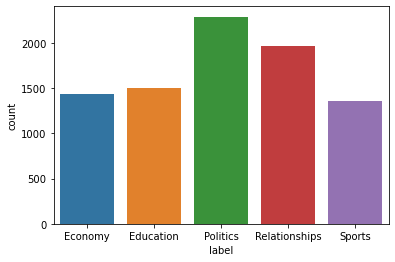

In [4]:
import seaborn as sns

sns.countplot(df.label)

## DATA CLEANING

In [5]:
df['text'] = df['text'].str.replace("\r", " ")
df['text'] = df['text'].str.replace("\n", " ")
df['text'] = df['text'].str.replace("    ", " ")
df['text'] = df['text'].str.replace('"', '')
df['text'] = df['text'].str.replace('"', '')

punctuation_signs = list(")(?:!.,;")

for punct_sign in punctuation_signs:
    df['text'] = df['text'].str.replace(punct_sign, ' ')

In [6]:
df['text'][0]

"finansal sektorun borclarini odeyememesi ile  enflasyonun da cok yukarilari ucmasi ile baslayacak krizdir  rant ekonomisinin sonu olacaktir  akp'nin de basimizdan gitmesi ile son bulacaktir "

In [7]:
import nltk
from nltk.corpus import stopwords
STOP_WORDS = list(stopwords.words('turkish'))

In [8]:
for stop_word in STOP_WORDS:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['text'] = df['text'].str.replace(regex_stopword, '')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
labels = {
    'Economy': 1,
    'Education': 2,
    'Politics':3,
    'Relationships':4,
    'Sports':5
}

df['label'] = df['label'].map(labels)

df['label'].value_counts()

3    2291
4    1967
2    1500
1    1432
5    1360
Name: label, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['label'], 
                                                    test_size=0.10, 
                                                    random_state=8)

In [12]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 1000

In [13]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(7695, 1000)
(855, 1000)


In [14]:
from sklearn.feature_selection import chi2
import numpy as np

for label, category_id in sorted(labels.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("")

# 'Economy' category:
  . Most correlated unigrams:
. piyasa
. kriz
. tl
. dolar
. bitcoin

# 'Education' category:
  . Most correlated unigrams:
. üniversitesi
. sınav
. üniversite
. okul
. hukuk

# 'Politics' category:
  . Most correlated unigrams:
. oy
. belediye
. akp
. chp
. parti

# 'Relationships' category:
  . Most correlated unigrams:
. erkek
. insandır
. aşık
. boşanmış
. kadın

# 'Sports' category:
  . Most correlated unigrams:
. futbol
. gol
. nba
. spor
. takım



In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

In [16]:
mnbc = MultinomialNB()
mnbc

MultinomialNB()

In [17]:
clf = MultinomialNB()

In [18]:
mnbc.fit(features_train, labels_train)

MultinomialNB()

In [19]:
mnbc_pred = mnbc.predict(features_test)

In [20]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

The training accuracy is: 
0.8088369070825211


In [21]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

The test accuracy is: 
0.7812865497076024


In [22]:
print("Classification report")
print(classification_report(labels_test,mnbc_pred))

Classification report
              precision    recall  f1-score   support

           1       0.90      0.61      0.73       154
           2       0.89      0.76      0.82       144
           3       0.69      0.91      0.79       231
           4       0.72      0.82      0.77       196
           5       0.94      0.72      0.82       130

    accuracy                           0.78       855
   macro avg       0.83      0.76      0.78       855
weighted avg       0.81      0.78      0.78       855



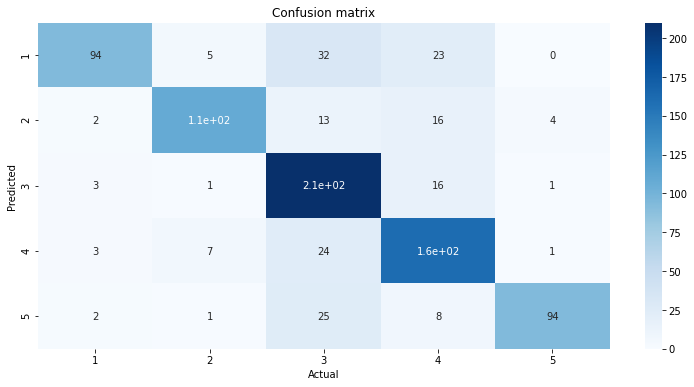

In [23]:
import matplotlib.pyplot as plt

aux_df = df[['label']].drop_duplicates().sort_values('label')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['label'].values, 
            yticklabels=aux_df['label'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [24]:
labels_test.value_counts()

3    231
4    196
1    154
2    144
5    130
Name: label, dtype: int64

In [25]:
np.unique(mnbc_pred, return_counts=True)

(array([1, 2, 3, 4, 5]), array([104, 123, 304, 224, 100]))

In [26]:
labels_keys = list(labels.keys())

## TESTING MODEL

In [27]:
my_tweets = np.array(["Doların bu kadar yükselmesi bizim için kötü oldu. Her geçen gün bilgisayar fiyatları artıyor.",
                    "Sınavın kolay olması üniversite sıralamalarını çok değiştirdi. Öğrenciler ne yapacaklarını şaşırdı.",
                     "Derbinin kazananı Beşiktaş oldu ve ligi 3.sırada bitirdi."])

tweet_features = tfidf.transform(my_tweets)

prediction = mnbc.predict(tweet_features)

for index, tweet in enumerate(my_tweets):
    category = labels_keys[prediction[index] - 1]
    cur_tweet = my_tweets[index]
    


    print("{} ----->> {}".format(cur_tweet, category))

Doların bu kadar yükselmesi bizim için kötü oldu. Her geçen gün bilgisayar fiyatları artıyor. ----->> Economy
Sınavın kolay olması üniversite sıralamalarını çok değiştirdi. Öğrenciler ne yapacaklarını şaşırdı. ----->> Education
Derbinin kazananı Beşiktaş oldu ve ligi 3.sırada bitirdi. ----->> Sports


In [28]:
list(labels.keys())

['Economy', 'Education', 'Politics', 'Relationships', 'Sports']